DATASET

In [1]:
!wget --no-check-certificate \
https://raw.githubusercontent.com/junjung214/Pemodelan-Simulasi-Data/master/Dataset.zip \
    -O /tmp/Dataset.zip

--2022-06-11 22:00:57--  https://raw.githubusercontent.com/junjung214/Pemodelan-Simulasi-Data/master/Dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52833927 (50M) [application/zip]
Saving to: ‘/tmp/Dataset.zip’

/tmp/Dataset.zip    100%[===================>]  50.39M  --.-KB/s    in 0.1s    

2022-06-11 22:00:58 (385 MB/s) - ‘/tmp/Dataset.zip’ saved [52833927/52833927]



In [2]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# Extract file zip dataset

import os
import zipfile

local_zip = '/tmp/Dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/Dataset'
test_dir = os.path.join(base_dir, 'Test')
train_dir = os.path.join(base_dir, 'Train')
val_dir = os.path.join(base_dir, 'Validation')

In [4]:
mask_train_path = train_dir + '/with_mask'
nomask_train_pat = train_dir + '/without_mask'
mask_val_path = val_dir + '/with_mask'
nomask_val_path = val_dir + '/without_mask'
mask_test_path = test_dir + '/with_mask'
nomask_test_path = test_dir + '/without_mask'

mask_len_train = len(os.listdir(mask_train_path))
nomask_len_train = len(os.listdir(nomask_train_pat))
mask_len_val = len(os.listdir(mask_val_path))
nomask_len_val = len(os.listdir(nomask_val_path))
mask_len_test = len(os.listdir(mask_test_path))
nomask_len_test = len(os.listdir(nomask_test_path))

print("jumlah dataset Training : ", mask_len_train + nomask_len_train)
print("jumlah dataset Validasi : ", mask_len_val + nomask_len_val)
print("jumlah dataset Test     : ", mask_len_test + nomask_len_test)
print("jumlah total Dataset    : ", mask_len_train + nomask_len_train + mask_len_val + nomask_len_val + mask_len_test + nomask_len_test)
print("\n\n")
print("jumlah train kelas Mask : ", mask_len_train)
print("jumlah train kelas No Mask : ", nomask_len_train)
print("jumlah validasi kelas Mask : ", mask_len_val)
print("jumlah validasi kelas No Mask : ", nomask_len_val)
print("jumlah test kelas Mask : ", mask_len_test)
print("jumlah test kelas No Mask : ", nomask_len_test)

jumlah dataset Training :  1100
jumlah dataset Validasi :  138
jumlah dataset Test     :  138
jumlah total Dataset    :  1376



jumlah train kelas Mask :  552
jumlah train kelas No Mask :  548
jumlah validasi kelas Mask :  69
jumlah validasi kelas No Mask :  69
jumlah test kelas Mask :  69
jumlah test kelas No Mask :  69


Augmentasi Dataset

In [5]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='binary')

Found 1100 images belonging to 2 classes.
Found 138 images belonging to 2 classes.


Library

In [7]:
'''
Import Library yang dibutuhkan
'''

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten,Dropout, BatchNormalization
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

Arsitektur Model

In [8]:
callbacks = EarlyStopping(monitor='val_loss', patience=25, verbose=1, mode='auto')        
directory_to_save_best_model_file = '/content/gdrive/MyDrive/Semester 6/Pemodelan dan Simulasi Data/Penelitian/Densenet.h5'
best_model = ModelCheckpoint(directory_to_save_best_model_file, monitor='val_accuracy', verbose = 1, save_best_only = True)

In [9]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

# import pretrain model in this case i use Resnet Model and setting the parameter "include_top" to false so i can change it
DenseNet_base = tf.keras.applications.densenet.DenseNet169(include_top=False, weights='imagenet',
                                                           input_tensor=None, input_shape=(224, 224,3))

51888128/51877672 [==============================] - 1s 0us/step


In [10]:
'''
melakukan setting bahwa model pretrained tidak akan dilatih ulang
'''

DenseNet_base.trainable = False

In [11]:
print('Adding new layers')
output = DenseNet_base.get_layer(index = -1).output  
output = Flatten()(output)
output = Dense(256,activation = "relu")(output)
output = BatchNormalization()(output)
output = Dropout(0.6)(output)
output = Dense(512,activation = "relu")(output)
output = BatchNormalization()(output)
output = Dropout(0.6)(output)
output = Dense(512,activation = "relu")(output)
output = BatchNormalization()(output)
output = Dropout(0.6)(output)
output = Dense(1, activation='sigmoid')(output) 
print('New layers Finishing Added!!!!')

Adding new layers
New layers Finishing Added!!!!


In [13]:
DenseNet_model = Model(DenseNet_base.input, output)


DenseNet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [14]:
import tensorflow as tf
from tensorflow.keras.applications.densenet import preprocess_input

DenseNet_model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.0001), loss='binary_crossentropy', 
                        metrics =['accuracy'])

In [15]:
history = DenseNet_model.fit_generator(
      train_generator,
      steps_per_epoch=55,  # images = batch_size * steps
      epochs=100,
      validation_data=validation_generator,
      validation_steps=7,  #  images = batch_size * steps
      callbacks = [callbacks, best_model])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/100
55/55 [==============================] - ETA: 0s - loss: 0.5966 - accuracy: 0.7291
Epoch 1: val_accuracy improved from -inf to 0.99275, saving model to /content/gdrive/MyDrive/Semester 6/Pemodelan dan Simulasi Data/Penelitian/Densenet.h5
55/55 [==============================] - 37s 428ms/step - loss: 0.5966 - accuracy: 0.7291 - val_loss: 0.1177 - val_accuracy: 0.9928
Epoch 2/100
55/55 [==============================] - ETA: 0s - loss: 0.3576 - accuracy: 0.8245
Epoch 2: val_accuracy improved from 0.99275 to 1.00000, saving model to /content/gdrive/MyDrive/Semester 6/Pemodelan dan Simulasi Data/Penelitian/Densenet.h5
55/55 [==============================] - 24s 443ms/step - loss: 0.3576 - accuracy: 0.8245 - val_loss: 0.0502 - val_accuracy: 1.0000
Epoch 3/100
55/55 [==============================] - ETA: 0s - loss: 0.2710 - accuracy: 0.8891
Epoch 3: val_accuracy did not improve from 1.00000
55/55 [==============================] - 17s 312ms/step - loss: 0.2710 - accuracy: 0.88

Evaluasi 

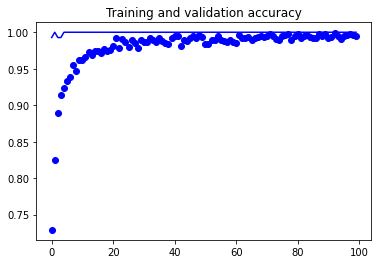

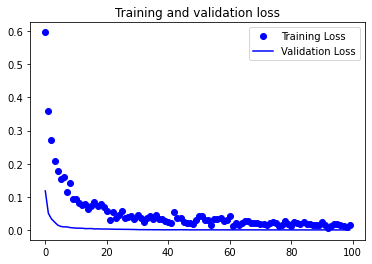

In [18]:
import matplotlib.pyplot as plt   
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [19]:
# import some of library that we need to look the confusion matrix, recall, f1_score, and accuracy score to look how much your model is well
import numpy as np 
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn import metrics

import seaborn as sns
sns.set(style='whitegrid')

In [20]:
# loading model to evaluate more depth
from keras.models import load_model
model_path = '/content/gdrive/MyDrive/Semester 6/Pemodelan dan Simulasi Data/Penelitian/Densenet.h5'
model = load_model(model_path)

Found 138 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


Accuracy  : 1.0
Precision : 1.0
f1Score : 1.0
[[69  0]
 [ 0 69]]


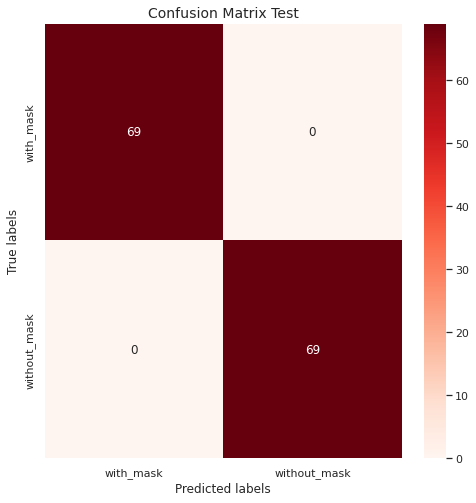

In [21]:
def my_metrics(y_true, y_pred):
    accuracy=accuracy_score(y_true, y_pred)
    precision=precision_score(y_true, y_pred,average='weighted')
    f1Score=f1_score(y_true, y_pred, average='weighted') 
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("f1Score : {}".format(f1Score))
    cm=confusion_matrix(y_true, y_pred)
    print(cm)
    return accuracy, precision, f1Score

height=224; width=224
batch_size=20

test_datagen = ImageDataGenerator(rescale=1./255)

TESTING_DIR = '/tmp/Dataset/Test'

test_generator = test_datagen.flow_from_directory(TESTING_DIR,
                                                  batch_size=batch_size,                                                             
                                                  target_size=(height, width),
                                                  class_mode= None,
                                                  shuffle=False
                                                  )

predictions = model.predict_generator(generator=test_generator)
yPredictions = predictions > 0.5
true_classes = test_generator.classes
class_names = test_generator.class_indices
Cmatrix_test = confusion_matrix(true_classes, yPredictions)

testAcc,testPrec, testFScore = my_metrics(true_classes, yPredictions)

plt.figure(figsize=(8,8))
ax= plt.subplot()
data = np.asarray(Cmatrix_test).reshape(2,2)
sns.heatmap(data,annot=True, fmt='',ax=ax, cmap=plt.cm.Reds)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_names)   
ax.yaxis.set_ticklabels(class_names)
plt.title('Confusion Matrix Test',fontsize=14)
plt.show()


In [22]:
from sklearn.metrics import classification_report
print(classification_report(true_classes, yPredictions, target_names=class_names))

              precision    recall  f1-score   support

   with_mask       1.00      1.00      1.00        69
without_mask       1.00      1.00      1.00        69

    accuracy                           1.00       138
   macro avg       1.00      1.00      1.00       138
weighted avg       1.00      1.00      1.00       138



Text(0.5, 1.0, 'Training and validation loss')

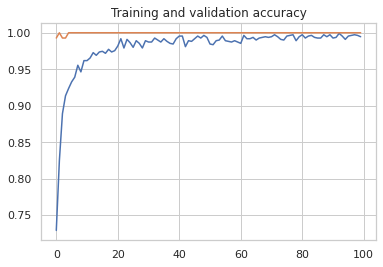

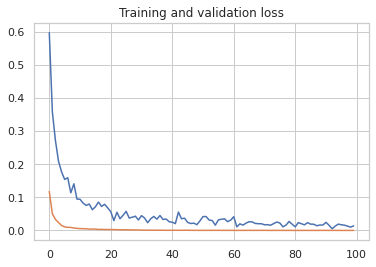

In [23]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )